# Лабораторная работа 1. Линейная регрессия и факторный анализ

## Описание работы

**Цель работы:** изучение основ линейной регрессии, построение простейших моделей регрессии, проведение обучения модели на реальных данных и оценка её качество.

**Постановка задачи:**

Провести обучение модели линейной регрессии на датасете с Kaggle:

1. Загрузить датасет из репозитория (например, kaggle.com или аналогичных платформ).

1. Подготовить данные: провести первичный анализ, визуализировать распределение признаков и целевой переменной. 

1. Провести предобработку данных: удалить пропущенные значения, закодировать категориальные переменные (опционально).

1. Построить матрицу корреляций. Сделать выводы о наличии мультиколлинеарности (расчет VIF-коэффициента).

1. Построить регрессионные модели (линейная и гребневая). Если целевая переменная - категориальная, то исследовать логистическую регрессию. Разделить на тренировочную и тестовую выборки (80/20 или 70/30). Использовать кросс-валидацию. Оценить качество построенной модели с помощью метрик: RMSE (Root Mean Square Error), R² (коэффициент детерминации) и MAPE (Mean Absolute Percentage Error).

1. Устранить мультиколлинеарность и снизить размерность признаков с помощью метода главных компонент (PCA). Перед проведением PCA провести стандартизацию данных.

1. Повторить шаг 5 (линейная и гребневая регрессия), но использовать в качестве признаков не исходные данные, а главные компоненты. Сравнить метрики качества (RMSE, R² и MAPE) моделей, обученных на исходных данных и на главных компонентах.

## Ход работы

**О датасете:** Этот набор данных содержит информацию о ценах на несколько моделей мобильных телефонов разных брендов. Он включает такие сведения, как объём памяти, объём оперативной памяти, размер экрана, характеристики камеры, ёмкость аккумулятора и цена каждого устройства.

**Столбцы:**

* Brand: производитель телефона

* Model: название модели телефона

* Storage (GB): объём памяти (в гигабайтах), доступной на телефоне

* RAM (GB): объём оперативной памяти (в гигабайтах), доступной на телефон

* Screen Size (inches): размер экрана телефона в дюймах

* Camera (MP): количество мегапикселей в основной камере (камерах) телефона

* Battery Capacity (mAh): ёмкость аккумулятора телефона в миллиампер-часах

* Price ($): розничная цена телефона в долларах США

Каждая строка соответствует отдельной модели мобильного телефона.

### 1 Загрузить датасет

Считаем данные из файла и выведим первые пять элементов

In [1103]:
import pandas as pd
import numpy as np

data = pd.read_csv('Mobile phone price.csv')

data.head()

,Brand,Model,Storage,RAM,Screen Size (inches),Camera (MP),Battery Capacity (mAh),Price ($)
0,Apple,iPhone 13 Pro,128 GB,6 GB,6.10,12 + 12 + 12,3095,999
1,Samsung,Galaxy S21 Ultra,256 GB,12 GB,6.80,108 + 10 + 10 + 12,5000,1199
2,OnePlus,9 Pro,128 GB,8 GB,6.70,48 + 50 + 8 + 2,4500,899
3,Xiaomi,Redmi Note 10 Pro,128 GB,6 GB,6.67,64 + 8 + 5 + 2,5020,279
4,Google,Pixel 6,128 GB,8 GB,6.40,50 + 12.2,4614,799


Целевой переменной является **Price ($)** — цена продажи. Именно ее и нужно научиться предсказывать.

Далее посмотрим с какими данными предстоит работать.

### 2. Подготовить данные: провести первичный анализ, визуализировать распределение признаков и целевой переменной. Провести предобработку данных.

In [1104]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 407 entries, 0 to 406
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Brand                   407 non-null    object 
 1   Model                   407 non-null    object 
 2   Storage                 407 non-null    object 
 3   RAM                     407 non-null    object 
 4   Screen Size (inches)    407 non-null    float64
 5   Camera (MP)             407 non-null    object 
 6   Battery Capacity (mAh)  407 non-null    int64  
 7   Price ($)               407 non-null    object 
dtypes: float64(1), int64(1), object(6)
memory usage: 25.6+ KB


Данные представлены в виде таблицы с 8 колонками, большинство из которых (6) хранятся в текстовом формате (object), что указывает на возможные проблемы с типизацией числовых данных. В частности, такие важные числовые характеристики как цена (Price ($)), объем памяти (Storage), оперативная память (RAM) и разрешение камеры (Camera (MP)) хранятся как текстовые значения, что потребует дополнительной предобработки перед анализом.

Проверим данные на наличие пропусков и пустых значений

In [1105]:
data.isna().sum()

Brand                     0
Model                     0
Storage                   0
RAM                       0
Screen Size (inches)      0
Camera (MP)               0
Battery Capacity (mAh)    0
Price ($)                 0
dtype: int64

Проверка подтвердила, что в датасете полностью отсутствуют пропущенные значения во всех колонках.

Далее удаляем категориальные признаки бренда и модели, затем проводится очистка и преобразование типов данных для остальных характеристик - из значений памяти и оперативной памяти удаляются текстовые обозначения "GB" с последующим преобразованием в целые числа, из ценовых значений убираются символы валюты и разделители разрядов.

In [1106]:
import re

data.drop(columns='Model', axis=1, inplace=True)

data.drop(columns='Brand', axis=1, inplace=True)

data['Storage']=data['Storage'].str.replace('GB', '').astype(int)

data['RAM']=data['RAM'].str.replace('GB', '').astype(int)

data['Price ($)']=data['Price ($)'].str.replace('$', '')
data['Price ($)']=data['Price ($)'].str.replace(',', '').astype(int)

data['Screen Size (inches)']=data['Screen Size (inches)'].astype(float)

def extract_camera_megapixels(camera_str):
    megapixels = re.findall(r'\d+\.*\d*', camera_str)
    return max([float(mp) for mp in megapixels])

data['Camera (MP)'] = data['Camera (MP)'].apply(extract_camera_megapixels)

data

,Storage,RAM,Screen Size (inches),Camera (MP),Battery Capacity (mAh),Price ($)
0,128,6,6.10,12.0,3095,999
1,256,12,6.80,108.0,5000,1199
2,128,8,6.70,50.0,4500,899
3,128,6,6.67,64.0,5020,279
4,128,8,6.40,50.0,4614,799
...,...,...,...,...,...,...
402,128,8,6.70,64.0,4300,1049
403,128,6,6.57,48.0,4160,349
404,128,6,6.70,12.0,3687,1099
405,128,8,6.40,48.0,4025,429


Также выведим основные статистические показатели

In [1107]:
data.describe().round(2)

,Storage,RAM,Screen Size (inches),Camera (MP),Battery Capacity (mAh),Price ($)
count,407.00,407.00,407.00,407.00,407.00,407.00
mean,123.05,5.84,6.47,43.79,4676.48,408.31
std,64.96,2.43,0.32,24.53,797.19,299.68
min,32.00,2.00,4.50,8.00,1821.00,99.00
25%,64.00,4.00,6.44,13.00,4300.00,199.00
50%,128.00,6.00,6.50,48.00,5000.00,299.00
75%,128.00,8.00,6.59,64.00,5000.00,499.00
max,512.00,16.00,7.60,108.00,7000.00,1999.00


Анализ описательной: цена устройств варьируется от бюджетных $99 до премиальных $1999 при среднем значении $408, при этом наиболее типичный сегмент сосредоточен вокруг медианной цены $299. Характеристики показывают стандартную конфигурацию со средним объемом памяти 128 ГБ, оперативной памятью 6 ГБ и емкостью батареи 5000 mAh, что соответствует современным рыночным тенденциям. Интересно отметить значительный разброс в характеристиках камер - от базовых 8 МП до продвинутых 108 МП при медианном значении 48 МП, а также относительно стабильный размер экрана вокруг 6.5 дюймов.

В целом, анализ показывает, что данные содержат признаки с разными шкалами, неоднородными распределениями, что требует нормализации и масштабирования перед применением методов машинного обучения

#### Графики распределения признаков

array([[<Axes: title={'center': 'Storage'}>,
        <Axes: title={'center': 'RAM'}>],
       [<Axes: title={'center': 'Screen Size (inches)'}>,
        <Axes: title={'center': 'Camera (MP)'}>],
       [<Axes: title={'center': 'Battery Capacity (mAh)'}>,
        <Axes: title={'center': 'Price ($)'}>]], dtype=object)

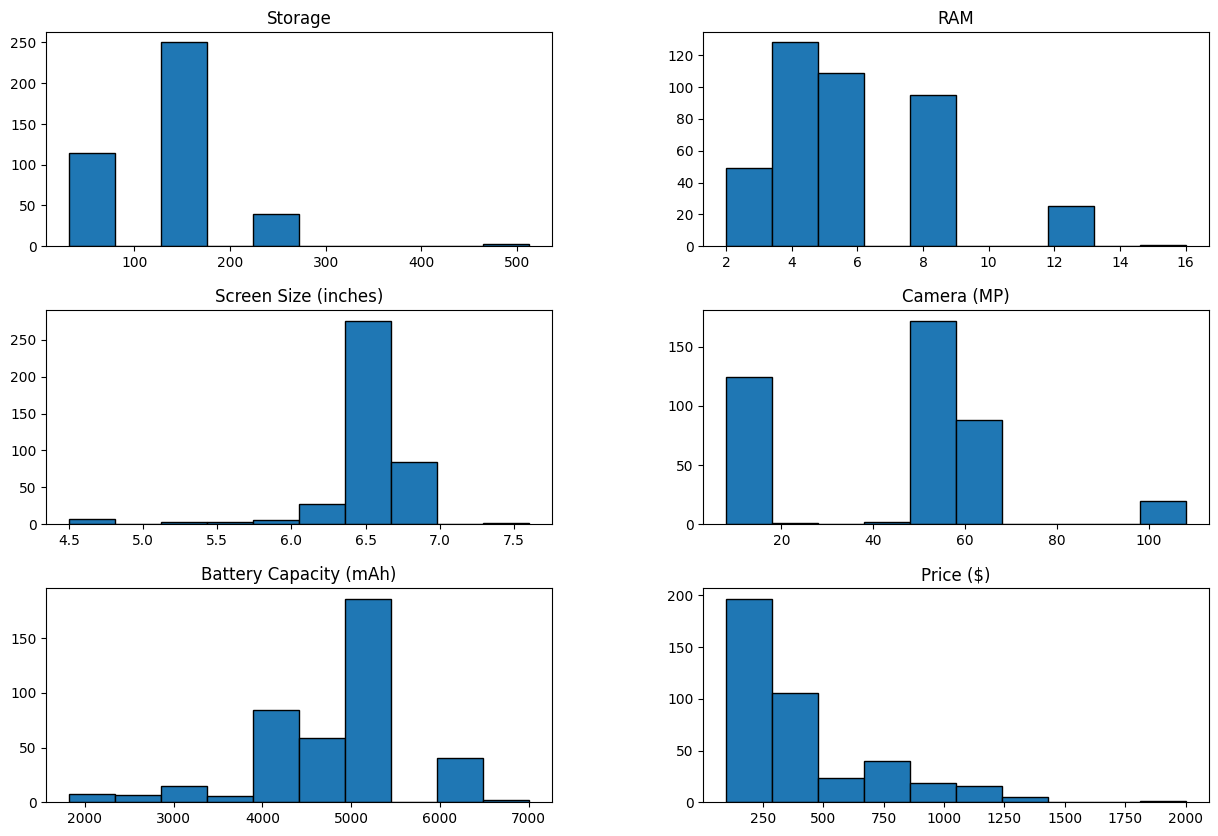

In [1108]:
data.hist(figsize=(15,10), grid=False, bins=10, edgecolor='black')

### 3 Построить матрицу корреляций. Сделать выводы о наличии мультиколлинеарности.

,Storage,RAM,Screen Size (inches),Camera (MP),Battery Capacity (mAh),Price ($)
Storage,1.00,0.69,0.26,0.39,-0.07,0.71
RAM,0.69,1.00,0.29,0.53,-0.03,0.64
Screen Size (inches),0.26,0.29,1.00,0.39,0.61,0.05
Camera (MP),0.39,0.53,0.39,1.00,0.29,0.16
Battery Capacity (mAh),-0.07,-0.03,0.61,0.29,1.00,-0.40
Price ($),0.71,0.64,0.05,0.16,-0.40,1.00


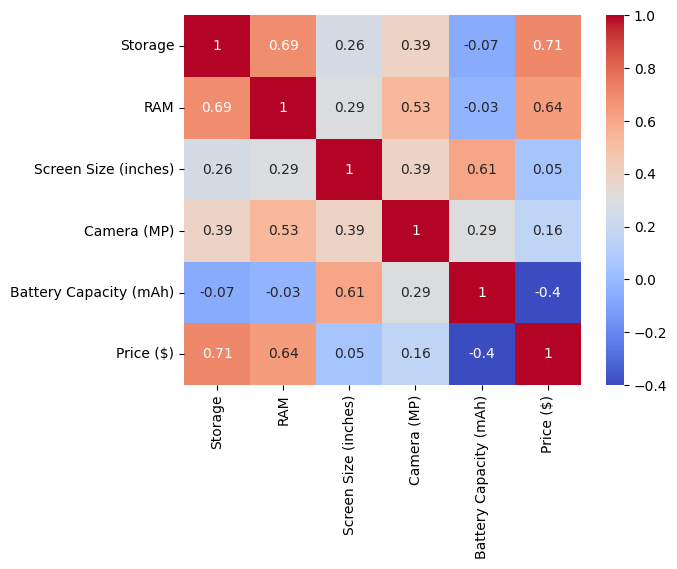

In [1109]:
import seaborn as sns

sns.heatmap(data.corr().round(2), annot=True,cmap="coolwarm")
data.corr().round(2)

Анализ корреляционной матрицы выявляет влияния характеристик на цену смартфонов. Объем памяти (0.71) и оперативная память (0.64) демонстрируют сильнейшую положительную корреляцию с ценой, что подтверждает их ключевую роль в ценообразовании. При этом емкость батареи (-0.40) показывает умеренную отрицательную корреляцию, что парадоксально — возможно, это связано с тем, что более дорогие ультратонкие модели жертвуют объемом аккумулятора в пользу дизайна. Размер экрана (0.05) и камера (0.16) практически не влияют на конечную стоимость, что указывает на их статус стандартизированных компонентов. Интересно отметить сильную взаимосвязь между основными характеристиками: память и оперативная память коррелируют на 0.69, формируя базовую конфигурацию устройства, в то время как размер экрана ожидаемо сильно связан с батареей (0.61) по физическим причинам.

Далее рассчитаем VIF-коэффициенты

In [1110]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X = add_constant(data)
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)


                  Feature         VIF
0                   const  534.260506
1                 Storage    2.701716
2                     RAM    2.736063
3    Screen Size (inches)    1.989783
4             Camera (MP)    1.678187
5  Battery Capacity (mAh)    2.327961
6               Price ($)    3.201845


Анализ VIF-коэффициентов показывает, что в данных отсутствует проблема мультиколлинеарности среди признаков-предикторов. Все VIF-значения для характеристик смартфонов находятся в диапазоне от 1.68 до 3.20, что значительно ниже общепринятого порога в 5-10, что свидетельствует о допустимом уровне корреляции между независимыми переменными.

### 4 Построить регрессионные модели (линейная и гребневая). Разделить на тренировочную и тестовую выборки (80/20 или 70/30). Использовать кросс-валидацию. Оценить качество построенной модели с помощью метрик: RMSE (Root Mean Square Error), R² (коэффициент детерминации) и MAPE (Mean Absolute Percentage Error)

Разделим выборку на тренировочную и тестовую часть с помощью функции train_test_split:

In [1111]:
from sklearn.model_selection import train_test_split

X = data.drop(columns='Price ($)')

y = data['Price ($)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

X_train: (325, 5)
X_test: (82, 5)
y_train: (325,)
y_test: (82,)


Данные успешно разделены в пропорции 80/20: обучающая выборка содержит 325 наблюдения с 5 признаками, тестовая - 82 наблюдения с теми же 5 признаками; целевая переменная имеет размеры, соответствующие выборкам (354 и 152).

Нормализация признаков. Метод стандартизации преобразует данные таким образом, чтобы каждый признак имел среднее значение 0 и стандартное отклонение 1, что предотвращает доминирование признаков с большими числовыми диапазонами и улучшает сходимость алгоритмов.

In [1112]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


#### Реализация линейной регрессии

In [1113]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

model_linear_reg = LinearRegression()

scores = cross_val_score(model_linear_reg, X_train_scaled, y_train, scoring='r2')
print(scores.round(3))
print(f"Средний R2: {scores.mean().round(3)}")
print(f"Стандартное отклонение: {scores.std().round(3)}")  


[0.743 0.536 0.684 0.608 0.68 ]
Средний R2: 0.65
Стандартное отклонение: 0.072


На основе результатов кросс-валидации модель демонстрирует удовлетворительную и стабильную предсказательную способность со средним R2 = 0.65. Это означает, что модель объясняет примерно 65% дисперсии целевой переменной (цены смартфонов), что является хорошим результатом для задачи регрессии в условиях реальных данных.

Далее обучим и сделаем прогноз

In [1114]:
model_linear_reg.fit(X_train_scaled, y_train)

y_pred = model_linear_reg.predict(X_test_scaled)

print(y_pred)

[ 8.44200370e+02  4.47063328e+02  4.68398768e+02  2.81269291e+02
  2.73124556e+01  9.03644850e+02  6.92044267e+02  2.07939373e+02
  1.38096149e+02  3.76008890e+02  5.71359771e+02  1.18693537e+02
  1.39921552e+02  5.09687690e+02  3.40084499e+02  4.69484384e+02
  5.57606008e+02  6.29492322e+02  4.41395091e+02  2.05122540e+02
  3.70436399e+02  5.42665842e+02  1.07029548e+02  1.39921552e+02
  3.73377271e+02  2.09922231e+02  2.08930802e+02  9.25273228e+01
  7.96927844e+02  4.69484384e+02  4.47618884e+02  5.07655973e+02
  2.86841782e+02  4.48088764e+02  1.08352221e+03  2.98907244e+02
  1.00762301e+03  3.69643575e+02  1.65775030e+02  6.59933214e+02
  3.69643575e+02  5.49990697e+02  3.69643575e+02  4.65175997e+02
  4.19585796e+02  4.63801039e+02  4.61322447e+01  4.46558544e+02
  1.07029548e+02  2.07019780e+02  3.76008890e+02  4.47063328e+02
  3.40084499e+02  4.47618884e+02 -5.20103212e+00  6.51598296e+02
  3.76008890e+02  2.86841782e+02  4.46105905e+02 -1.57798394e+00
  5.04851866e+02  2.07019

Посчитаем метрики качества модели

In [1115]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error, r2_score

rmse_model_linear_reg = root_mean_squared_error(y_test, y_pred)
r2_model_linear_reg = r2_score(y_test, y_pred)
mape_model_linear_reg = mean_absolute_percentage_error(y_test, y_pred)
print(f'RMSE: {rmse_model_linear_reg}')
print(f'R2: {r2_model_linear_reg}')
print(f'MAPE: {mape_model_linear_reg}')


RMSE: 160.69131201239665
R2: 0.6765992552182674
MAPE: 0.36744099489415083


Модель демонстрирует удовлетворительное качество прогнозирования (R2=0.68), со средней абсолютной ошибкой в $161, однако относительная ошибка в 36.7% указывает на ограниченную точность для крайних ценовых сегментов, где ключевую роль играют неучтенные факторы, такие как бренд и статус устройства.

#### Реализация гребневой регрессии

In [1116]:
from sklearn.linear_model import Ridge

model_ridge = Ridge(alpha=.5)
cv_scores = cross_val_score(model_ridge, X_train_scaled, y_train, cv=5, scoring='r2') 
print(cv_scores.round(3))
print(f"Средний R2: {cv_scores.mean().round(3)}")
print(f"Стандартное отклонение: {cv_scores.std().round(3)}") 
model_ridge.fit(X_train_scaled,y_train)

y_pred = model_ridge.predict(X_test_scaled)
print(y_pred)

rmse_model_linear_ridge = root_mean_squared_error(y_test, y_pred)
r2_model_linear_ridge = r2_score(y_test, y_pred)
mape_model_linear_ridge = mean_absolute_percentage_error(y_test, y_pred)


print(f'RMSE: {rmse_model_linear_ridge}')
print(f'R2: {r2_model_linear_ridge}')
print(f'MAPE: {mape_model_linear_ridge}')

[0.743 0.536 0.685 0.608 0.681]
Средний R2: 0.65
Стандартное отклонение: 0.071
[ 8.43691938e+02  4.47384126e+02  4.68217031e+02  2.81708701e+02
  2.77522548e+01  9.02689202e+02  6.91863484e+02  2.07996406e+02
  1.38573507e+02  3.76104316e+02  5.71212039e+02  1.18760286e+02
  1.40261503e+02  5.09672920e+02  3.40344839e+02  4.69470960e+02
  5.57412862e+02  6.29005315e+02  4.41216061e+02  2.05323462e+02
  3.70803870e+02  5.42281190e+02  1.07155745e+02  1.40261503e+02
  3.73481158e+02  2.09966300e+02  2.08981353e+02  9.26981572e+01
  7.96051144e+02  4.69470960e+02  4.47633797e+02  5.07645335e+02
  2.87009147e+02  4.48154009e+02  1.08233022e+03  2.99677048e+02
  1.00700741e+03  3.69676017e+02  1.66378521e+02  6.59979497e+02
  3.69676017e+02  5.49880028e+02  3.69676017e+02  4.65199486e+02
  4.19653238e+02  4.63472250e+02  4.63465194e+01  4.46434610e+02
  1.07155745e+02  2.07069750e+02  3.76104316e+02  4.47384126e+02
  3.40344839e+02  4.47633797e+02 -4.56603075e+00  6.50907718e+02
  3.7610431

Результаты гребневой регрессии показывают, что добавление регуляризации незначительно повлияло на качество модели по сравнению с обычной линейной регрессией. Среднее значение коэффициента детерминации на кросс-валидации составило около 0.65, а итоговый R2 = 0.6768, что практически совпадает с результатом линейной модели (0.6765). Это означает, что Ridge-регрессия объясняет примерно 67% дисперсии целевой переменной, сохраняя при этом аналогичный уровень точности.

Ошибка RMSE равна 160, а средняя абсолютная процентная ошибка (MAPE) составляет 36.7%, что почти идентично метрикам линейной регрессии. Таким образом, добавление регуляризации не ухудшило качество предсказаний, но позволило сделать модель немного более устойчивой к мультиколлинеарности между признаками.

### 5 Устранить мультиколлинеарность и снизить размерность признаков с помощью метода главных компонент (PCA).

Попробуем снизить размерность признаков с помощью метода главных компонент

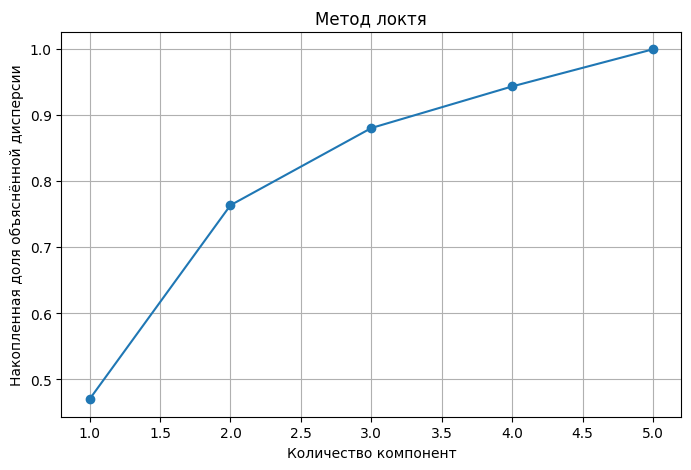

array([0.47005095, 0.7637923 , 0.88068357, 0.94371503, 1.        ])

In [1117]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_train_scaled)
explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='-')
plt.title('Метод локтя')
plt.xlabel('Количество компонент')
plt.ylabel('Накопленная доля объяснённой дисперсии')
plt.grid(True)
plt.show()
explained_variance

На графике видно, что для сохранения 88% дисперсии данных достаточно трех главных компонент, при этом первые две компоненты объясняют 76% дисперсии, а первая компонента — почти половину (47%). Выбираем 2 компоненты.

#### Линейная регрессия после PCA

In [1118]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X)

new_pca = PCA(n_components=2)
X_train_pca = new_pca.fit_transform(X_train_scaled)
print(X_train_pca.shape)

X_train, X_test, Y_train, Y_test = train_test_split(X_train_pca, y, test_size=0.2, random_state=42)


model = LinearRegression()
cv_scores = cross_val_score(model, X_train, Y_train, cv=5, scoring='r2')
model.fit(X_train, Y_train)

print(f"Результаты кросс-валидации (R²): {cv_scores}")

y_pred = model.predict(X_test)


LinearRMSE_PCA = root_mean_squared_error(Y_test, y_pred)
LinearR2_PCA = r2_score(Y_test, y_pred)
LinearMAPE_PCA = mean_absolute_percentage_error(Y_test, y_pred)
print('RMSE:', LinearRMSE_PCA)
print('R2:', LinearR2_PCA)
print('MAPE:', LinearMAPE_PCA)

(407, 2)
Результаты кросс-валидации (R²): [0.71349082 0.62624836 0.53561174 0.49898219 0.60693465]
RMSE: 185.75347505881885
R2: 0.6224240641943976
MAPE: 0.3400174652865288


Применение PCA с 2 компонентами привело к снижению качества модели по сравнению с использованием всех исходных признаков: R2 уменьшился с 0.68 до 0.62, а RMSE возросло с 161 до 186. Хотя MAPE незначительно улучшился (с 36.7% до 34.0%), что может указывать на лучшее предсказание относительных цен, общее ухудшение основных метрик свидетельствует о том, что сокращение размерности до 2 компонент привело к потере важной информации, влияющей на прогнозирование стоимости смартфонов, несмотря на сохранение 76% дисперсии данных.

#### Гребневая регрессия после PCA

In [1119]:
new_pca = PCA(n_components=2)
X_train_pca = new_pca.fit_transform(X_train_scaled)
print(X_train_pca.shape)

X_train, X_test, Y_train, Y_test = train_test_split(X_train_pca, y, test_size=0.2, random_state=42)


model = Ridge(alpha=.5)
cv_scores = cross_val_score(model, X_train, Y_train, cv=5, scoring='r2')
model.fit(X_train, Y_train)

print(f"Результаты кросс-валидации (R²): {cv_scores}")

y_pred = model.predict(X_test)

RidgeRMSE_PCA = root_mean_squared_error(Y_test, y_pred)
RidgeR2_PCA = r2_score(Y_test, y_pred)
RidgeMAPE_PCA = mean_absolute_percentage_error(Y_test, y_pred)
print('RMSE:', RidgeRMSE_PCA)
print('R2:', RidgeR2_PCA)
print('MAPE:', RidgeMAPE_PCA)

(407, 2)
Результаты кросс-валидации (R²): [0.71347282 0.62621102 0.5361235  0.49901509 0.60673397]
RMSE: 185.75842878657565
R2: 0.6224039253158844
MAPE: 0.33987179491567815


Сокращение числа компонент до 2 при гребневой регрессии привело к существенному ухудшению качества модели: R² снизился до 0.62, а RMSE вырос до 186, что практически идентично результатам линейной регрессии с двумя компонентами и подтверждает, что уменьшение размерности до 2 компонент приводит к потере важной информации, несмотря на применение регуляризации.

### Сравнительный анализ

In [1121]:
results = pd.DataFrame({
    'Модель': [
        'Линейная регрессия (без PCA)',
        'Гребневая регрессия (без PCA)',
        'Линейная регрессия (с PCA)',
        'Гребневая регрессия (с PCA)'
    ],
    'RMSE': [
        rmse_model_linear_reg,
        rmse_model_linear_ridge,
        LinearRMSE_PCA,
        RidgeRMSE_PCA
    ],
    'MAPE': [
        mape_model_linear_reg,
        mape_model_linear_ridge,
        LinearMAPE_PCA,
        RidgeMAPE_PCA
    ],
    'R2': [
        r2_model_linear_reg,
        r2_model_linear_ridge,
        LinearR2_PCA,
        RidgeR2_PCA
    ]
})

print('\nСравнительная таблица метрик качества моделей:')
print(results.round(4))


Сравнительная таблица метрик качества моделей:
                          Модель      RMSE    MAPE      R2
0   Линейная регрессия (без PCA)  160.6913  0.3674  0.6766
1  Гребневая регрессия (без PCA)  160.6259  0.3671  0.6769
2     Линейная регрессия (с PCA)  185.7535  0.3400  0.6224
3    Гребневая регрессия (с PCA)  185.7584  0.3399  0.6224


Анализ сравнительной таблицы выявляет, что наилучшие результаты показывает исходная линейная и гребневая регрессия без применения PCA с максимальным R2 (∼0.677) и минимальной RMSE (∼160.7). Применение PCA с 2 компонентами, несмотря на незначительное улучшение MAPE (∼0.34 против ∼0.367), существенно ухудшило основную метрику качества R2 на 8%, что свидетельствует о потере релевантной информации при сокращении размерности. Таким образом, для данного набора данных использование PCA нецелесообразно, и оптимальным выбором является модель гребневой регрессии на исходных признаках.